# Regression Models

In [22]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy

from matplotlib.patches import Rectangle

In [23]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [24]:
sns.set_style('whitegrid')

## Read in data

In [25]:
data = pd.read_csv("data/HourlyDataCleanedFinal.csv")

In [26]:
data.head()

,Date,Day of Week,Hour,WorkGroup,TotalEnergy,HourlyEnergy,Name,Weekend_Indicator,Treatment_A_Indicator,Treatment_B_Indicator,Treatment_control_Indicator,Treatment_Administered_Indicator,NonParticipant,DailyLoginCount,DailyDurationCount,OutOfOffice
0,2018-06-01,Friday,8.0,WORKGROUP-01,11.22,NaN,Ken,0,0,0,0,0,0,0.0,0.0,1
1,2018-06-01,Friday,9.0,WORKGROUP-01,0.00,NaN,Ken,0,0,0,0,0,0,0.0,0.0,1
2,2018-06-01,Friday,10.0,WORKGROUP-01,0.22,0.22,Ken,0,0,0,0,0,0,0.0,0.0,1
3,2018-06-01,Friday,11.0,WORKGROUP-01,0.45,0.23,Ken,0,0,0,0,0,0,0.0,0.0,1
4,2018-06-01,Friday,12.0,WORKGROUP-01,0.68,0.23,Ken,0,0,0,0,0,0,0.0,0.0,1


### Weather data

In [27]:
weather = pd.read_csv("data/weather.csv")

In [28]:
weather.head()

,Unnamed: 0,Date,DailyRainfallTotal,Highest30MinRainfall,Highest60MinRainfall,Highest120MinRainfall,MeanTemperature,MaximumTemperature,MinimumTemperature,MeanWindSpeed,MaxWindSpeed
0,0,2018-06-01,16.4,5.0,8.4,13.6,28.1,30.1,24.5,9.0,42.1
1,1,2018-06-02,5.8,1.4,2.6,4.6,27.7,29.7,24.1,9.7,58.7
2,2,2018-06-03,0.0,0.0,0.0,0.0,29.1,31.8,26.8,9.7,24.5
3,3,2018-06-04,0.6,0.6,0.6,0.6,29.6,31.2,26.0,9.7,36.7
4,4,2018-06-05,0.0,0.0,0.0,0.0,30.0,31.7,28.3,9.7,24.5


In [29]:
# using final weather features
weather_features = ['Date',
                    'MeanTemperature',
                    'MaximumTemperature',
                    'DailyRainfallTotal',
                    'Highest30MinRainfall',
                    'Highest60MinRainfall']
weather = weather[weather_features]
data = data.merge(weather, how='left', on='Date')

## Manipulation

### Add month variable

In [30]:
# not using it for now
data['Month'] = data['Date'].str.slice(5,7).astype(int)
data.head()

,Date,Day of Week,Hour,WorkGroup,TotalEnergy,HourlyEnergy,Name,Weekend_Indicator,Treatment_A_Indicator,Treatment_B_Indicator,...,NonParticipant,DailyLoginCount,DailyDurationCount,OutOfOffice,MeanTemperature,MaximumTemperature,DailyRainfallTotal,Highest30MinRainfall,Highest60MinRainfall,Month
0,2018-06-01,Friday,8.0,WORKGROUP-01,11.22,NaN,Ken,0,0,0,...,0,0.0,0.0,1,28.1,30.1,16.4,5.0,8.4,6
1,2018-06-01,Friday,9.0,WORKGROUP-01,0.00,NaN,Ken,0,0,0,...,0,0.0,0.0,1,28.1,30.1,16.4,5.0,8.4,6
2,2018-06-01,Friday,10.0,WORKGROUP-01,0.22,0.22,Ken,0,0,0,...,0,0.0,0.0,1,28.1,30.1,16.4,5.0,8.4,6
3,2018-06-01,Friday,11.0,WORKGROUP-01,0.45,0.23,Ken,0,0,0,...,0,0.0,0.0,1,28.1,30.1,16.4,5.0,8.4,6
4,2018-06-01,Friday,12.0,WORKGROUP-01,0.68,0.23,Ken,0,0,0,...,0,0.0,0.0,1,28.1,30.1,16.4,5.0,8.4,6


In [31]:
data['Datetime'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

### Get rid of NA rows

In [32]:
data_clean = data.dropna(subset=['HourlyEnergy'])

In [33]:
data_clean['Hour'].value_counts().sort_index()

0.0     9801
1.0     9808
2.0     9764
3.0     9778
4.0     9777
5.0     9771
6.0     9762
7.0     9754
8.0     7932
9.0     2851
10.0    7650
11.0    9646
12.0    9715
13.0    9733
14.0    9755
15.0    9758
16.0    9760
17.0    9761
18.0    9764
19.0    9784
20.0    9799
21.0    9800
22.0    9789
23.0    9797
Name: Hour, dtype: int64

In [34]:
data_clean['Name'].nunique()

28

### Get rid of Out Of Office

In [35]:
is_out_of_office = (data_clean['OutOfOffice'] == 1)
data_clean = data_clean[~is_out_of_office]

In [36]:
data_clean = data_clean.drop('OutOfOffice', axis='columns')

In [37]:
len(data_clean)

148880

In [38]:
data_clean = data_clean.rename(columns={'Day of Week': 'DayOfWeek'})

In [39]:
data_clean.head()

,Date,DayOfWeek,Hour,WorkGroup,TotalEnergy,HourlyEnergy,Name,Weekend_Indicator,Treatment_A_Indicator,Treatment_B_Indicator,...,NonParticipant,DailyLoginCount,DailyDurationCount,MeanTemperature,MaximumTemperature,DailyRainfallTotal,Highest30MinRainfall,Highest60MinRainfall,Month,Datetime
736,2018-07-02,Monday,0.0,WORKGROUP-01,284.35,7.52,Ken,0,0,0,...,0,0.0,0.0,27.7,28.7,0.6,0.6,0.6,7,2018-07-02
737,2018-07-02,Monday,1.0,WORKGROUP-01,302.35,18.00,Ken,0,0,0,...,0,0.0,0.0,27.7,28.7,0.6,0.6,0.6,7,2018-07-02
738,2018-07-02,Monday,2.0,WORKGROUP-01,347.83,45.48,Ken,0,0,0,...,0,0.0,0.0,27.7,28.7,0.6,0.6,0.6,7,2018-07-02
739,2018-07-02,Monday,3.0,WORKGROUP-01,391.39,43.56,Ken,0,0,0,...,0,0.0,0.0,27.7,28.7,0.6,0.6,0.6,7,2018-07-02
740,2018-07-02,Monday,4.0,WORKGROUP-01,426.03,34.64,Ken,0,0,0,...,0,0.0,0.0,27.7,28.7,0.6,0.6,0.6,7,2018-07-02


## Split by date

In [40]:
start_date = pd.to_datetime('2018-08-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2018-10-10', format='%Y-%m-%d')

is_before = (data_clean['Datetime'] <= start_date)
is_during = ((data_clean['Datetime'] > start_date) & (data_clean['Datetime'] <= end_date))
is_after = (data_clean['Datetime'] > end_date)

# data_before = data.loc[is_before]
# data_during = data.loc[is_during]
# data_after = data.loc[is_after]

## During period

In [41]:
data_during = data_clean.loc[is_during]

In [42]:
data_during.head()

,Date,DayOfWeek,Hour,WorkGroup,TotalEnergy,HourlyEnergy,Name,Weekend_Indicator,Treatment_A_Indicator,Treatment_B_Indicator,...,NonParticipant,DailyLoginCount,DailyDurationCount,MeanTemperature,MaximumTemperature,DailyRainfallTotal,Highest30MinRainfall,Highest60MinRainfall,Month,Datetime
1480,2018-08-02,Thursday,0.0,WORKGROUP-01,263.08,0.92,Ken,0,1,0,...,0,3.0,6.0,28.1,29.6,0.0,0.0,0.0,8,2018-08-02
1481,2018-08-02,Thursday,1.0,WORKGROUP-01,264.00,0.92,Ken,0,1,0,...,0,3.0,6.0,28.1,29.6,0.0,0.0,0.0,8,2018-08-02
1482,2018-08-02,Thursday,2.0,WORKGROUP-01,264.93,0.93,Ken,0,1,0,...,0,3.0,6.0,28.1,29.6,0.0,0.0,0.0,8,2018-08-02
1483,2018-08-02,Thursday,3.0,WORKGROUP-01,264.93,0.00,Ken,0,1,0,...,0,3.0,6.0,28.1,29.6,0.0,0.0,0.0,8,2018-08-02
1484,2018-08-02,Thursday,4.0,WORKGROUP-01,359.34,94.41,Ken,0,1,0,...,0,3.0,6.0,28.1,29.6,0.0,0.0,0.0,8,2018-08-02


In [43]:
features_drop = ['Date',
                 'Treatment_Administered_Indicator',
                 'Datetime',
                 'TotalEnergy',
                 'WorkGroup',
                 'Month', #is not significant
                 'DayOfWeek' # just keep the weekend indicator
                ]
data_during_design = data_during.drop(features_drop, axis='columns')

In [44]:
data_during_design['Hour'] = data_during_design['Hour'].astype(int).astype(str)

In [45]:
data_during_dummies = pd.get_dummies(data_during_design, drop_first=False)
data_during_dummies.head()

,HourlyEnergy,Weekend_Indicator,Treatment_A_Indicator,Treatment_B_Indicator,Treatment_control_Indicator,NonParticipant,DailyLoginCount,DailyDurationCount,MeanTemperature,MaximumTemperature,...,Name_Pandarasamy,Name_Prakhar,Name_Ramit,Name_Sivaraam,Name_Sneha,Name_Toby Cheung,Name_Vicky,Name_Viveka,Name_You Chun,Name_Zuraimi
1480,0.92,0,1,0,0,0,3.0,6.0,28.1,29.6,...,0,0,0,0,0,0,0,0,0,0
1481,0.92,0,1,0,0,0,3.0,6.0,28.1,29.6,...,0,0,0,0,0,0,0,0,0,0
1482,0.93,0,1,0,0,0,3.0,6.0,28.1,29.6,...,0,0,0,0,0,0,0,0,0,0
1483,0.00,0,1,0,0,0,3.0,6.0,28.1,29.6,...,0,0,0,0,0,0,0,0,0,0
1484,94.41,0,1,0,0,0,3.0,6.0,28.1,29.6,...,0,0,0,0,0,0,0,0,0,0


In [46]:
data_during_dummies = data_during_dummies.drop(['Hour_0', 'Name_Ajeet'], axis=1)

In [47]:
y = data_during_dummies['HourlyEnergy']
X = data_during_dummies.drop('HourlyEnergy', axis='columns')
X = sm.add_constant(X)

/home/miguel/anaconda3/envs/ieor242/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HourlyEnergy   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     808.9
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:02:34   Log-Likelihood:            -1.1154e+05
No. Observations:               22648   AIC:                         2.232e+05
Df Residuals:                   22587   BIC:                         2.237e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           7.2810      6.926      1.051      0.293      -6.295      20.857
Weekend_Indicator              -8.8216      0.797    -11.066      0.000     -10.384      -7.259
Treatment_A_Indicator         -13.9753      1.929     -7.244      0.000     -17.757     -10.194
Treatment_B_Indicator         -12.0633      2.072     -5.821      0.000     -16.125      -8.001
Treatment_control_Indicator   -13.6839      2.363     -5.791      0.000     -18.315      -9.053
NonParticipant                 47.0035      1.732     27.134      0.000      43.608      50.399
DailyLoginCount                -0.9122      0.448     -2.036      0.042      -1.791      -0.034
DailyDurationCount             -0.0840      0.132     -0.634      0.526      -0.344       0.176
MeanTemperature                 2.8903      0.586      4.929      0.000       1.741       4.040
MaximumTemperature             -1.6763      0.502     -3.340      0.001      -2.660      -0.692
DailyRainfallTotal             -0.0023      0.127     -0.018      0.985      -0.251       0.246
Highest30MinRainfall            0.4006      0.176      2.280      0.023       0.056       0.745
Highest60MinRainfall           -0.4454      0.198     -2.255      0.024      -0.833      -0.058
Hour_1                          1.0685      1.493      0.716      0.474      -1.858       3.995
Hour_10                       -34.5046      1.631    -21.150      0.000     -37.702     -31.307
Hour_11                       -31.8784      1.503    -21.211      0.000     -34.824     -28.933
Hour_12                       -31.7519      1.501    -21.149      0.000     -34.695     -28.809
Hour_13                       -32.1694      1.496    -21.497      0.000     -35.103     -29.236
Hour_14                       -30.7544      1.494    -20.579      0.000     -33.684     -27.825
Hour_15                       -32.3984      1.488    -21.780      0.000     -35.314     -29.483
Hour_16                       -32.2614      1.488    -21.678      0.000     -35.178     -29.344
Hour_17                       -32.7885      1.494    -21.951      0.000     -35.716     -29.861
Hour_18                       -26.6076      1.487    -17.891      0.000     -29.523     -23.693
Hour_19                       -14.5094      1.496     -9.699      0.000     -17.442     -11.577
Hour_2                          0.3648      1.490      0.245      0.807      -2.556       3.286
Hour_20                        -9.8362      1.490     -6.600      0.000     -12.757      -6.915
Hour_21                        -8.5997      1.498     -5.740      0.000     -11.536      -5.663
Hour_22                        -9.3446      1.497     -6.243      0.000     -12.278      -6.411
Hour_23                       -11.5253      1.487     -7.752      0.000     -14.439      -8.611
Hour_3     

In [51]:
# MAE
train_predictions = results.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
# RMSE
train_RMSE = np.sqrt(mean_squared_error(y_train, train_predictions))
# R2
train_R2 = results.rsquared

In [52]:
train_R2

0.6824108170318666

In [58]:
predictions = results.predict(X_test)
# test OSR2
test_RSS = np.sum((y_test - predictions) ** 2)
test_TSS = np.sum((y_test - y_train.mean()) ** 2)
OSR2 = 1 - test_RSS/test_TSS
# test RMSE
test_RMSE = np.sqrt(np.mean((y_test - predictions) ** 2))
# test MAE
test_MAE = mean_absolute_error(y_test, predictions)

In [59]:
print(test_RMSE, test_MAE, OSR2)

30.608322656504477 18.046635272942996 0.7056596426694803


#### Visualizations

In [66]:
def lollipop_plot(names, values, color='darkblue', save=False):
    my_range = range(1, len(names)+1)
    plt.vlines(x=my_range,
               ymin=0,
               ymax=values,
               color=color
              )
    plt.plot(my_range, values, "o", color=color)

    # Add titles and axis names
    plt.xticks(my_range, names)
    plt.title('Regression parameters')
    plt.ylabel('Value of the parameter')
    plt.xlabel('Feature')

    if save:
        plt.savefig('regression_parameters.png')

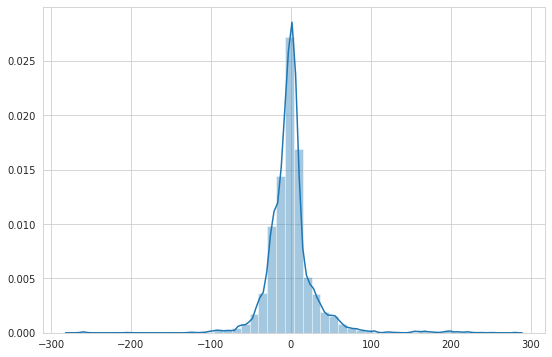

In [140]:
residuals = y_test - predictions
sns.distplot(residuals);

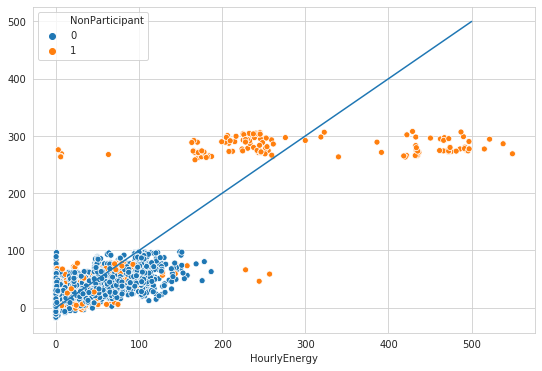

In [141]:
fig, ax = plt.subplots()
sns.scatterplot(y_test, predictions,
                hue=X_test['NonParticipant'],
                ax=ax)
plt.plot(np.linspace(0, 500), np.linspace(0, 500));

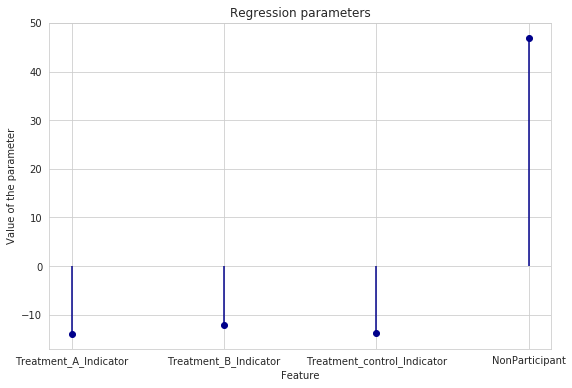

In [142]:
significant_vars = ['Treatment_A_Indicator',
                    'Treatment_B_Indicator',
                    'Treatment_control_Indicator',
                    'NonParticipant']
betas = results.params[significant_vars]

lollipop_plot(significant_vars, betas)

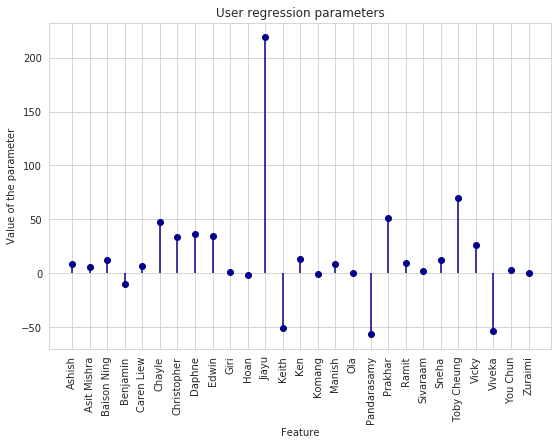

In [143]:
is_user_column = results.params.index.str.startswith('Name')
user_vars = list(results.params.index[is_user_column])
user_names = [var[5:] for var in user_vars]
betas_users = results.params[user_vars]

lollipop_plot(user_names, betas_users)
plt.title('User regression parameters')
plt.xticks(rotation=90)
plt.savefig('user_coefficients_during.png');

***

### Interaction terms

#### Design matrix and output labels

In [69]:
X = data_during_design
y = data_during_design['HourlyEnergy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Fit model

In [70]:
model_interaction = smf.ols(formula=interaction_formula, data=X_train)
results_interaction = model_interaction.fit()
results_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HourlyEnergy   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     378.5
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:08:00   Log-Likelihood:            -1.1146e+05
No. Observations:               22648   AIC:                         2.232e+05
Df Residuals:                   22518   BIC:                         2.242e+05
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -22.1936      8.584     -2.586      0.010     -39.018      -5.369
C(Name)[T.Ashish]                           8.3116      2.601      3.195      0.001       3.213      13.410
C(Name)[T.Asit Mishra]                      6.0483      1.719      3.519      0.000       2.680       9.417
C(Name)[T.Baison Ning]                     12.2329      1.651      7.411      0.000       8.998      15.468
C(Name)[T.Benjamin]                        33.9438      1.749     19.405      0.000      30.515      37.372
C(Name)[T.Caren Liew]                       6.3114      1.745      3.617      0.000       2.891       9.731
C(Name)[T.Chayle]                          47.0966      1.758     26.790      0.000      43.651      50.542
C(Name)[T.Christopher]                     33.4472      1.711     19.551      0.000      30.094      36.800
C(Name)[T.Daphne]                          36.1429      1.629     22.192      0.000      32.951      39.335
C(Name)[T.Edwin]                           34.0680      2.238     15.224      0.000      29.682      38.454
C(Name)[T.Giri]                             0.8372      1.860      0.450      0.653      -2.808       4.482
C(Name)[T.Hoan]                            -2.1856      1.930     -1.133      0.257      -5.968       1.596
C(Name)[T.Jiayu]                          263.3420      1.760    149.618      0.000     259.892     266.792
C(Name)[T.Keith]                           -6.4748      1.625     -3.985      0.000      -9.659      -3.290
C(Name)[T.Ken]                             13.3085      1.793      7.422      0.000       9.794      16.823
C(Name)[T.Komang]                          -0.8006      1.887     -0.424      0.671      -4.499       2.898
C(Name)[T.Manish]                           8.0469      1.846      4.359      0.000       4.428      11.666
C(Name)[T.Ola]                              0.0304      2.080      0.015      0.988      -4.047       4.108
C(Name)[T.Pandarasamy]                    -12.1341      1.592     -7.621      0.000     -15.255      -9.013
C(Name)[T.Prakhar]                         50.7316      1.692     29.985      0.000      47.415      54.048
C(Name)[T.Ramit]                            9.5282      1.895      5.029      0.000       5.815      13.242
C(Name)[T.Sivaraam]                         2.2233      1.900      1.170      0.242      -1.500       5.947
C(Name)[T.Sneha]                           12.1759      2.343      5.198      0.000       7.584      16.767
C(Name)[T.Toby Cheung]                     70.0838      1.583     44.266      0.000      66.981      73.187
C(Name)[T.Vicky]                           26.3231      1.853     14.209      0.000      22.692      29.954
C(Name)[T.Viveka]                          -9.7204      1.9

#### Visualization of feature impact

In [71]:
hour_A_vars = ['C(Hour)[' + str(i) + ']:Treatment_A_Indicator' for i in range(0, 24)]
betas_A_hours = results_interaction.params[hour_A_vars]

hour_labels = ['Hour_' + str(i) for i in range(0, 24)]

hour_B_vars = ['C(Hour)[' + str(i) + ']:Treatment_B_Indicator' for i in range(0, 24)]
betas_B_hours = results_interaction.params[hour_B_vars]

hour_control_vars = ['C(Hour)[' + str(i) + ']:Treatment_control_Indicator' for i in range(0, 24)]
betas_control_hours = results_interaction.params[hour_control_vars]

hour_non_vars = ['C(Hour)[' + str(i) + ']:NonParticipant' for i in range(0, 24)]
betas_non_hours = results_interaction.params[hour_non_vars]

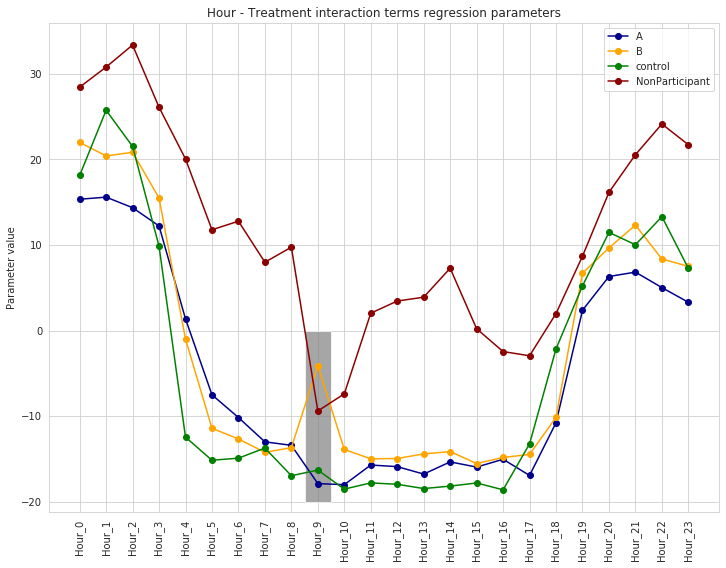

In [73]:
plt.figure(figsize=(12,9))
plt.plot(hour_labels, betas_A_hours, color='darkblue', marker='o')
plt.plot(hour_labels, betas_B_hours, color='orange', marker='o')
plt.plot(hour_labels, betas_control_hours, color='green', marker='o')
plt.plot(hour_labels, betas_non_hours, color='darkred', marker='o')

plt.xticks(rotation=90)
plt.title('Hour - Treatment interaction terms regression parameters')
plt.ylabel('Parameter value')
plt.legend(['A', 'B', 'control', 'NonParticipant'])

ax = plt.gca()
ax.add_patch(Rectangle((8.5, -20), 1, 20, facecolor='grey', alpha=0.7))

plt.savefig('interaction_parameters_line.png');

#### Model performance

In [74]:
# MAE
train_predictions = results_interaction.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
# RMSE
train_RMSE = np.sqrt(mean_squared_error(y_train, train_predictions))
# R2
train_R2 = results_interaction.rsquared

In [75]:
train_R2

0.6844025528105068

In [77]:
predictions = results_interaction.predict(X_test)
# test OSR2
test_RSS = np.sum((y_test - predictions) ** 2)
test_TSS = np.sum((y_test - y_train.mean()) ** 2)
OSR2 = 1 - test_RSS/test_TSS
# test RMSE
test_RMSE = np.sqrt(np.mean((y_test - predictions) ** 2))
# test MAE
test_MAE = mean_absolute_error(y_test, predictions)

In [78]:
print(test_RMSE, test_MAE, OSR2)

30.654042739529913 18.163994719560293 0.7047796652607431


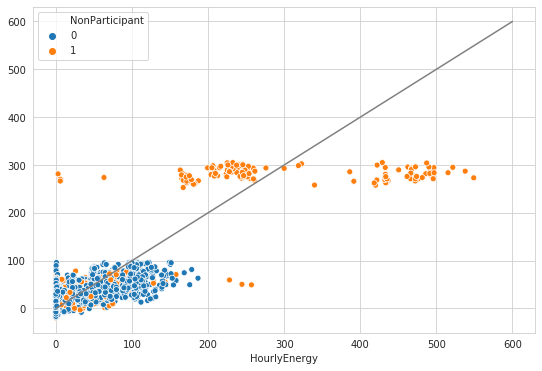

In [156]:
fig, ax = plt.subplots()
sns.scatterplot(y_test, predictions,
                hue=X_test['NonParticipant'],
                ax=ax)
plt.plot(np.linspace(0, 600), np.linspace(0, 600), color="grey")
plt.savefig('prediction_scatter.png');

***